In [133]:
import numpy as np
import pandas as pd
import networkx as nx
from collections import defaultdict
import matplotlib.pyplot as plt
import time
import random as random


## Extracting Dataset Information

In [2]:
from dataset_utils import convert_to_graph, generate_disease_dict, filter_diseases

diseases = pd.read_csv("./Datasets/disease_targets.tsv", sep='\t')

drug_target_data = np.loadtxt("./Datasets/drug_targets.txt", dtype=[('drug', 'U50'), ('target', int)])

interactome_data = np.loadtxt("./Datasets/interactome.txt", dtype={'names': ('proteinA', 'proteinB', 'source'), 'formats': ('int', 'int', 'str')})

interactome_graph = convert_to_graph(interactome_data)
    
disease_gene_dict = generate_disease_dict(diseases,interactome_graph)
    
drug_to_targets = defaultdict(list)
for rec in drug_target_data:
    drug_to_targets[rec['drug']].append(int(rec['target']))
    
filtered_disease_dict = filter_diseases(disease_gene_dict, interactome_graph)

### Example Interactome subgraph

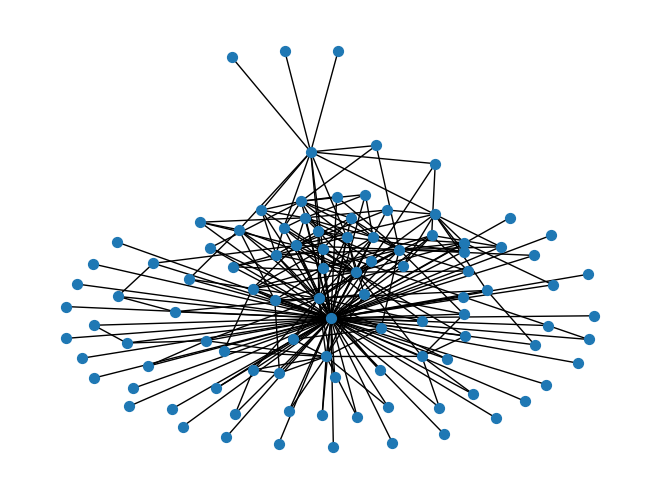

In [18]:
H = interactome_graph.subgraph(list(interactome_graph.nodes())[:100])
pos = nx.spring_layout(H)
nx.draw(H, pos, node_size=50, with_labels=False)
plt.show()

### Fetching Drug Combinations

In [28]:
from dataset_utils import load_and_merge_combinations

combinations_df = load_and_merge_combinations("./Datasets/disease_drug_combinations.tsv", diseases)

print(combinations_df.head())

  Disease ID             Drug Combination  Num Drugs  \
0   C0033578  (DB00007, DB00014, DB01128)          3   
1   C0024299           (DB00541, DB00987)          2   
2   C0024141  (DB00091, DB00860, DB01611)          3   
3   C0011849           (DB01076, DB01261)          2   
4   C0003811           (DB00661, DB04855)          2   

                    Disease Name  
0            Prostatic Neoplasms  
1                       Lymphoma  
2  Lupus Erythematosus, Systemic  
3              Diabetes Mellitus  
4             Cardiac Arrhythmia  


In [23]:
from dataset_utils import get_drug_combinations_and_unique_drugs

combos, drugs = get_drug_combinations_and_unique_drugs("Diabetes Mellitus", combinations_df)
print("Combinations for Diabetes Mellitus:", combos)
print("Unique drugs:", drugs)

Combinations for Diabetes Mellitus: [('DB01076', 'DB01261'), ('DB00678', 'DB01261'), ('DB00641', 'DB00678'), ('DB00331', 'DB00641'), ('DB00331', 'DB01261'), ('DB00412', 'DB00678'), ('DB00331', 'DB01076'), ('DB00284', 'DB00331'), ('DB00331', 'DB01261', 'DB06655'), ('DB00331', 'DB00412', 'DB01132'), ('DB01261', 'DB06655'), ('DB00678', 'DB01132'), ('DB00331', 'DB06655'), ('DB00222', 'DB00331', 'DB01132'), ('DB00284', 'DB01076'), ('DB01120', 'DB01261'), ('DB00222', 'DB00284', 'DB01261'), ('DB00222', 'DB00412'), ('DB00222', 'DB00331', 'DB00641'), ('DB00222', 'DB00331', 'DB01261'), ('DB00222', 'DB00331'), ('DB00491', 'DB01083'), ('DB00284', 'DB00331', 'DB01261'), ('DB00331', 'DB01083'), ('DB00331', 'DB01016'), ('DB00222', 'DB00331', 'DB00412'), ('DB01029', 'DB01076'), ('DB01076', 'DB01132'), ('DB01083', 'DB06655'), ('DB00222', 'DB00331', 'DB06655'), ('DB00222', 'DB00331', 'DB01076', 'DB01261'), ('DB00222', 'DB00331', 'DB01120'), ('DB00678', 'DB01120'), ('DB00222', 'DB01076'), ('DB00284', 'DB

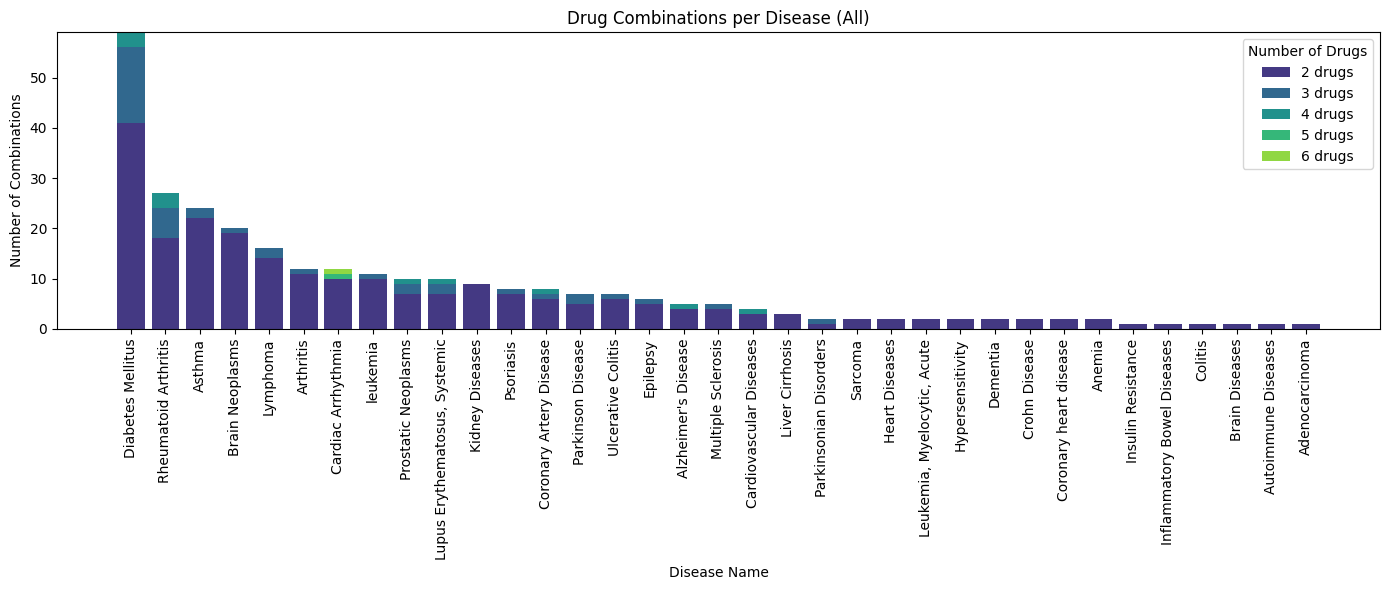

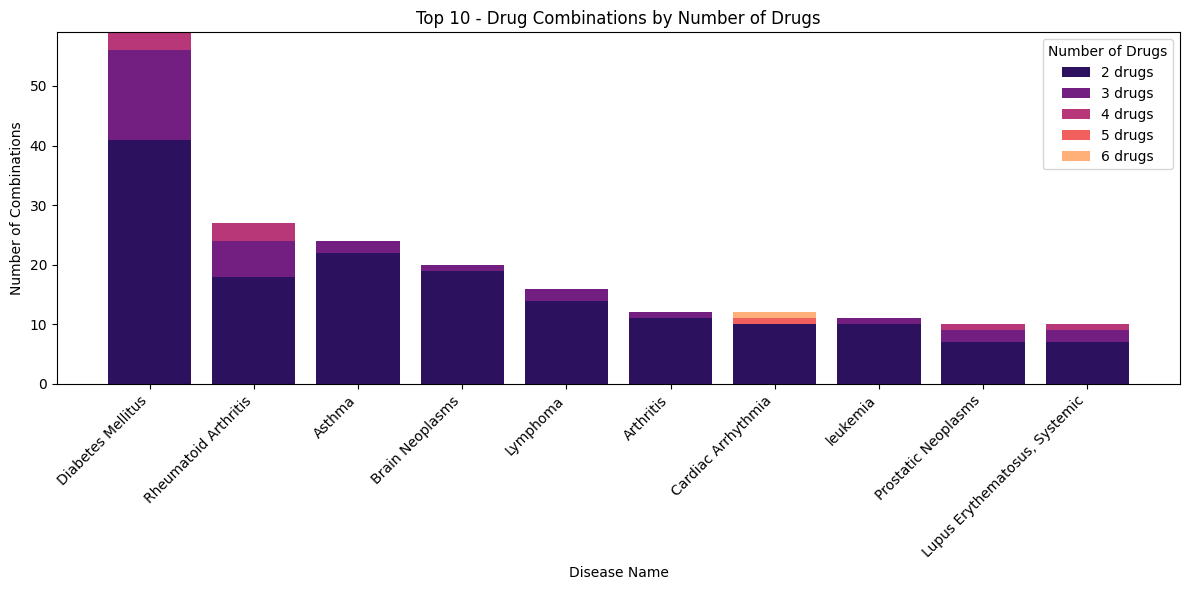

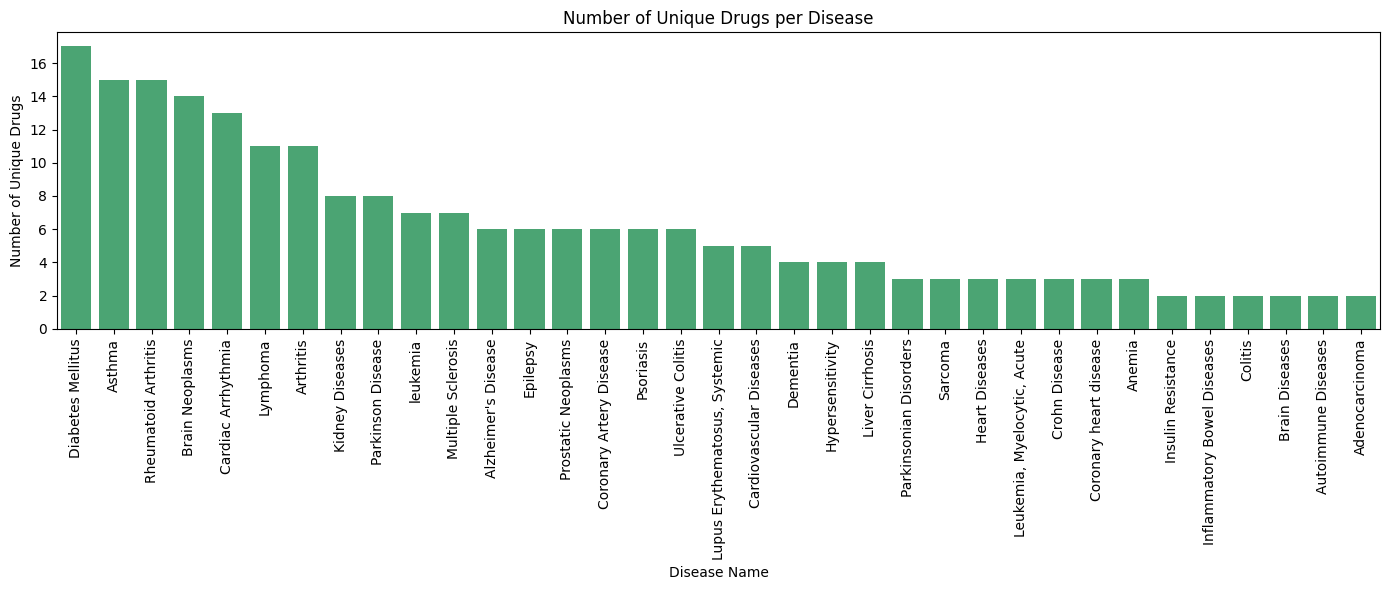

In [26]:
from dataset_utils import plot_combination_info
plot_combination_info(combinations_df)


### Precomputing All-Pairs-Shortest-Path Matrix

In [12]:
from distance_metrics import precompute_apsp

print("Precomputing All-Pairs-Shortest-Path Matrix.")
print("This may take several minutes...")
t_i=time.time()

dist_matrix, nodes, node_to_idx = precompute_apsp(interactome_graph)

print(f"Took {time.time() - t_i:.2f} seconds to compute APSP matrix")


Precomputing All-Pairs-Shortest-Path Matrix.
This may take several minutes...
Took 840.95 seconds to compute APSP matrix


# Optimizing Hyperparameters



$$
\text{Power‐weighted Rank Metric}:\quad
L_{\mathrm{w-rank}}
=\frac{1}{|\mathcal C|}\sum_{c\in\mathcal C}
\biggl(\frac{M - \mathrm{rank}(c) + 1}{M}\biggr)^{p} \quad\text{where}\;\mathrm{rank}(c)=1+\bigl|\{\,E_i<E_c\}\bigr|\,,\;
M=2^n

$$


In [339]:
import importlib, distance_metrics, dataset_utils, qubo_selection, parameter_optimization, scaling_estimation
importlib.reload(distance_metrics)
importlib.reload(dataset_utils)
importlib.reload(qubo_selection)
importlib.reload(parameter_optimization)
importlib.reload(scaling_estimation)

<module 'scaling_estimation' from 'c:\\Users\\dmra\\Documents\\Drug-Combinations-using-Quantum-Annealers\\scaling_estimation.py'>

Selected drugs: ['DB00262', 'DB00541', 'DB00563', 'DB00570', 'DB00635', 'DB00860', 'DB00987', 'DB00997', 'DB01033', 'DB01073', 'DB01206']
Best AP: 0.5213 at gamma=3.544303797468359, beta=8.9873417721519
Best Rank: 0.6296 at gamma=26.835443037974684, beta=34.30379746835443


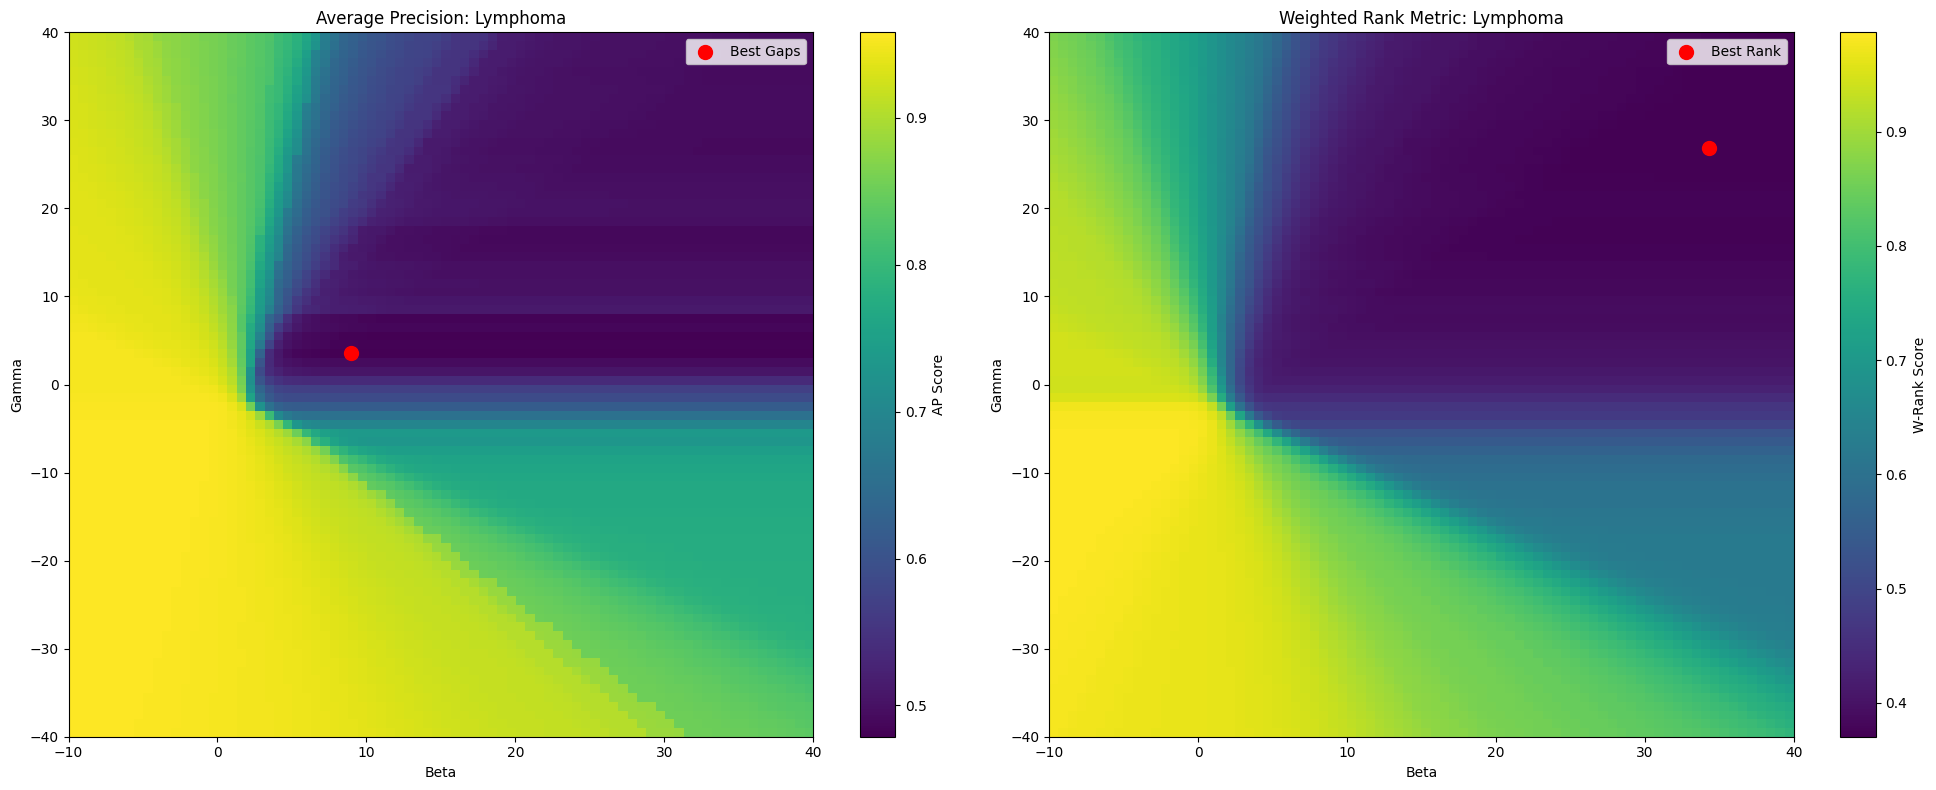

In [131]:
from parameter_optimization import optimize_with_metrics, get_ground_truth_combinations, get_exact_low_energy_states, plot_metric_results, plot_energy_spectrum, plot_and_compute_precision_recall_curve

disease = 'Lymphoma'
num_trials = 1 # for testing different random drug paddings if wanted 
z_score_samples = 3000  
gamma_grid = np.linspace(-40, 40, 80)
beta_grid = np.linspace(-10, 40, 80)

combos, initial_drug_ids = get_drug_combinations_and_unique_drugs(disease, combinations_df)
num_qubits = len(initial_drug_ids) # Use all unique drugs in the verified combinations for this disease

results = optimize_with_metrics(
    disease_name=disease,
    df=combinations_df,
    interactome_graph=interactome_graph,
    filtered_disease_dict=filtered_disease_dict,
    drug_to_targets=drug_to_targets,
    dist_matrix=dist_matrix,
    nodes=nodes,
    node_to_idx=node_to_idx,
    num_qubits=num_qubits,
    gamma_values=gamma_grid,
    beta_values=beta_grid,
    initial_drug_ids=initial_drug_ids,
    num_trials=num_trials,
    num_samples=z_score_samples
)

(best_ap_drug_ids, best_ap_score, best_ap_qubo, best_ap_gamma, best_ap_beta,
best_rank_drug_ids, best_rank_score, best_rank_qubo, best_rank_gamma, best_rank_beta,
metric_matrices) = results

print(f"Best AP: {best_ap_score:.4f} at gamma={best_ap_gamma}, beta={best_ap_beta}")
print(f"Best Rank: {best_rank_score:.4f} at gamma={best_rank_gamma}, beta={best_rank_beta}")

plot_metric_results(metric_matrices, gamma_grid, beta_grid, disease)

gt_combinations = get_ground_truth_combinations(disease, combinations_df)


### Maximizing for Average Precision (AP)

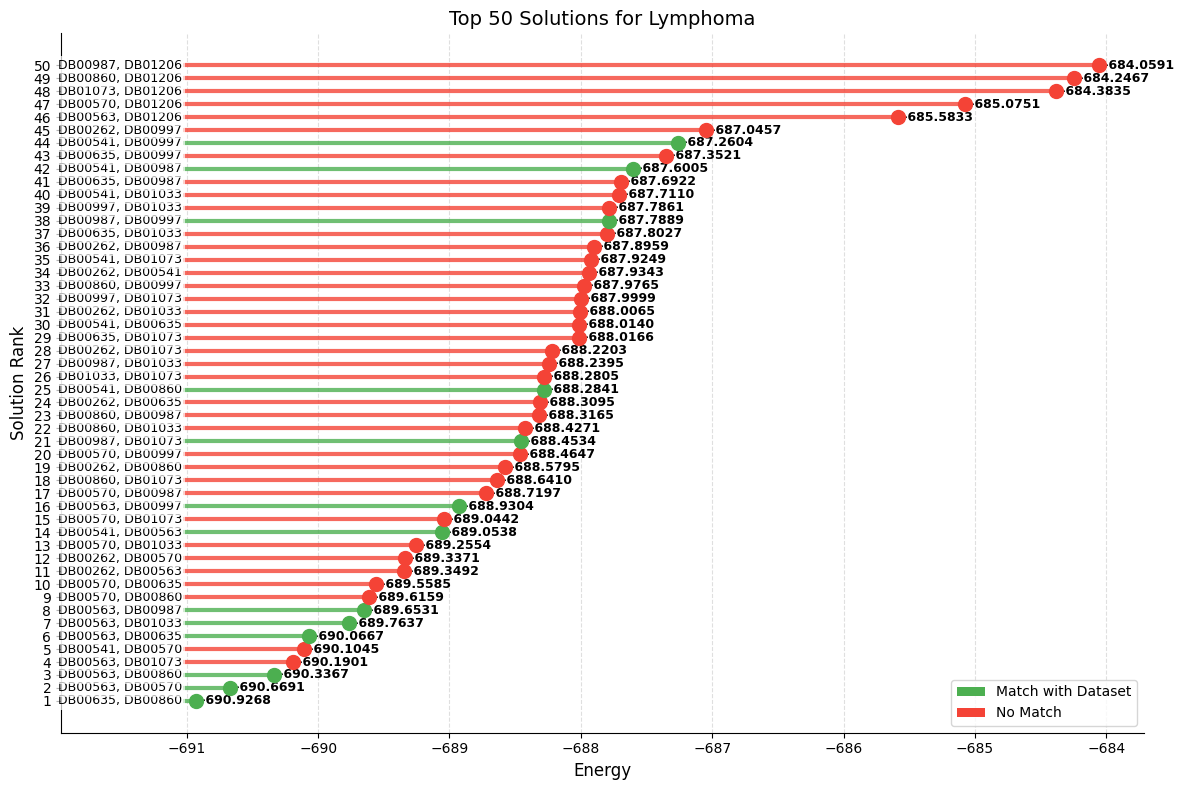

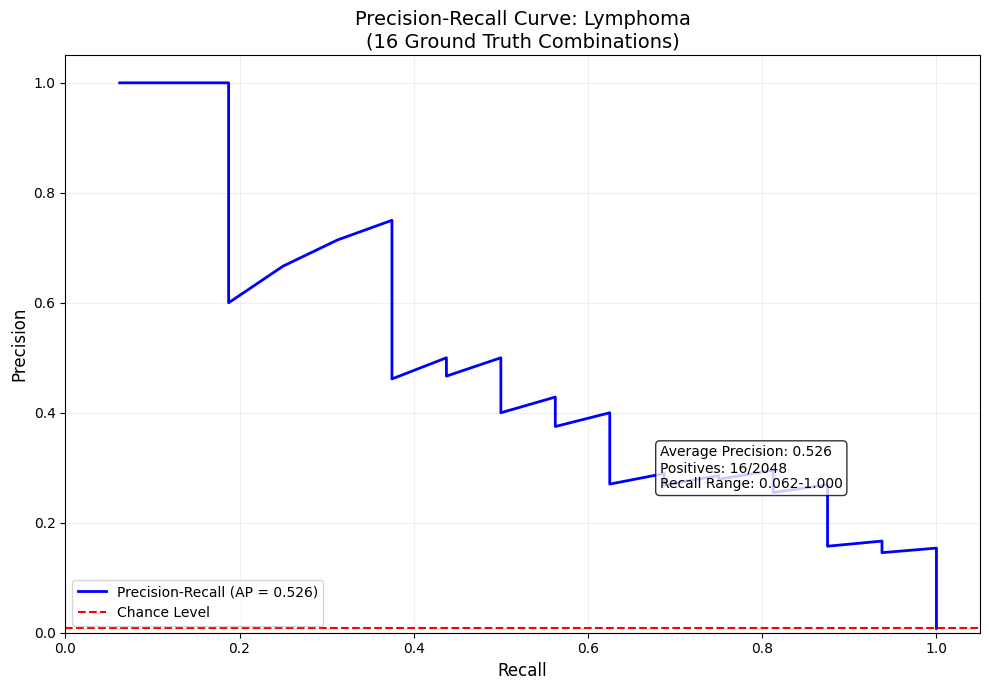

In [90]:
exact_results = get_exact_low_energy_states(
    qubo=best_ap_qubo,
    drug_ids=best_ap_drug_ids,
    gt_combinations=gt_combinations,
    max_states=5000,      # Return up to this number of states
    energy_threshold=10000.0  # Only states within this energy of ground state
)

plot_energy_spectrum(
    sorted_results=exact_results,
    top_n=50,
    disease_name=disease
)

ap, precision, recall = plot_and_compute_precision_recall_curve(
    sorted_results=exact_results,
    gt_combinations=gt_combinations,
    disease_name=disease
)


### Maximizing for Weighted-Rank Metric

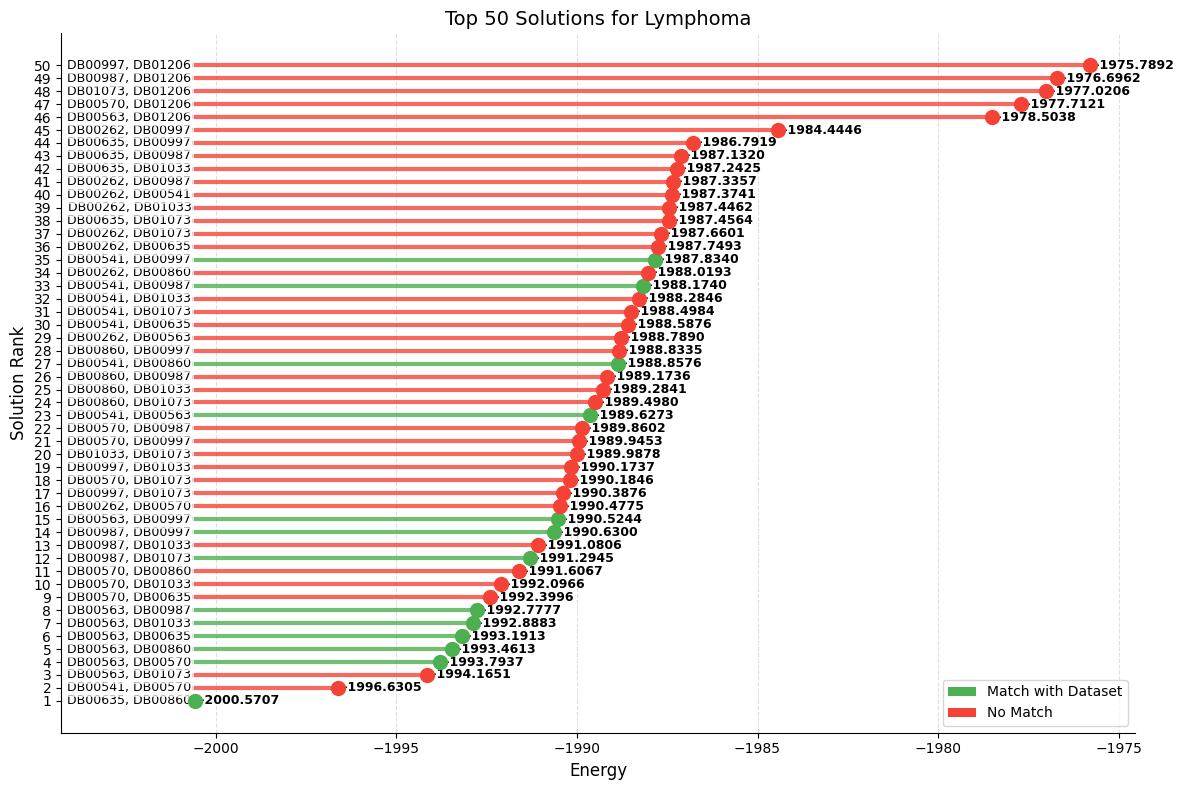

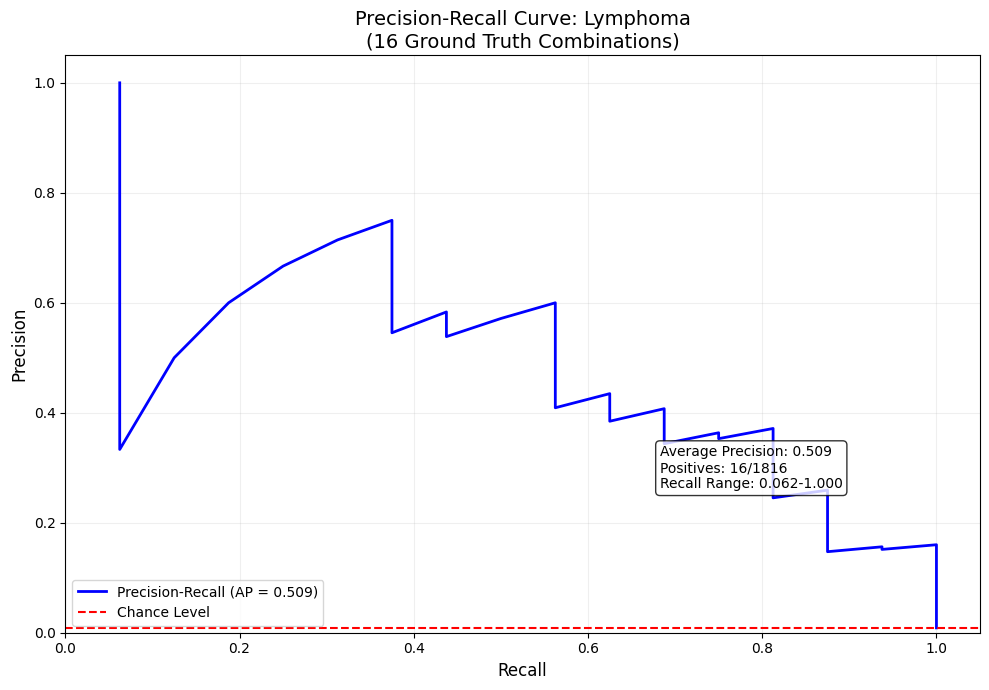

In [91]:
exact_results = get_exact_low_energy_states(
    qubo=best_rank_qubo,
    drug_ids=best_rank_drug_ids,
    gt_combinations=gt_combinations,
    max_states=5000,      
    energy_threshold=10000.0 
)

plot_energy_spectrum(
    sorted_results=exact_results,
    top_n=50,
    disease_name=disease
)

ap, precision, recall = plot_and_compute_precision_recall_curve(
    sorted_results=exact_results,
    gt_combinations=gt_combinations,
    disease_name=disease
)


### Scaling the number of qubits for proof of concept

Enumerated 220 candidates; positives=16; AP=0.522288
 #1: energy=-692.143, pos=1, sel=('DB00635', 'DB00860')
 #2: energy=-691.892, pos=1, sel=('DB00563', 'DB00570')
 #3: energy=-691.501, pos=1, sel=('DB00563', 'DB00860')
 #4: energy=-691.383, pos=0, sel=('DB00563', 'DB01073')
 #5: energy=-691.362, pos=0, sel=('DB00541', 'DB00570')
 #6: energy=-691.3, pos=1, sel=('DB00563', 'DB00635')
 #7: energy=-690.974, pos=1, sel=('DB00563', 'DB01033')
 #8: energy=-690.869, pos=1, sel=('DB00563', 'DB00987')
 #9: energy=-690.834, pos=0, sel=('DB00570', 'DB00635')
 #10: energy=-690.822, pos=0, sel=('DB00570', 'DB00860')


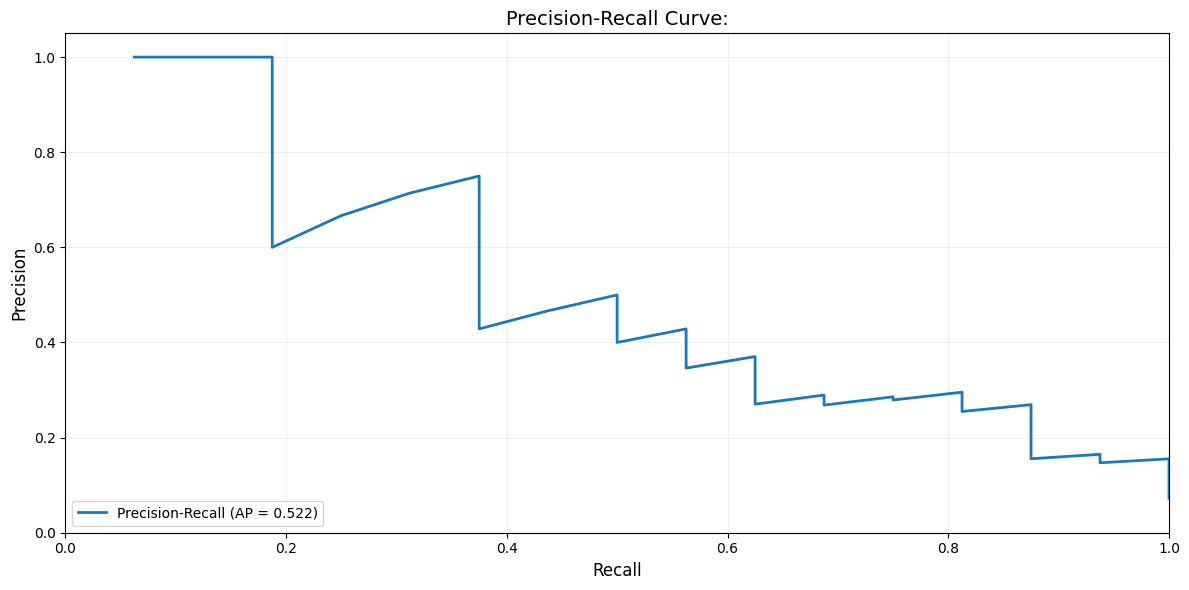

[Trial 0] ap=0.522288


In [117]:
from qubo_selection import find_best_qubo_for_params_ap_enumeration
allowed_sizes=[2,3]
return_curve=True

best_drugs, best_qubo, best_ap, trials = find_best_qubo_for_params_ap_enumeration(
    disease_name=disease,
    df=combinations_df,
    interactome_graph=interactome_graph,
    filtered_disease_dict=filtered_disease_dict,
    drug_to_targets=drug_to_targets,
    dist_matrix=dist_matrix,
    nodes=nodes,
    node_to_idx=node_to_idx,
    initial_drug_ids=initial_drug_ids,
    num_qubits=num_qubits,
    gamma=best_ap_gamma,
    beta=best_ap_beta,
    num_trials=num_trials,
    num_samples_for_z=z_score_samples,
    allowed_sizes=allowed_sizes,
    return_curve=return_curve,
)

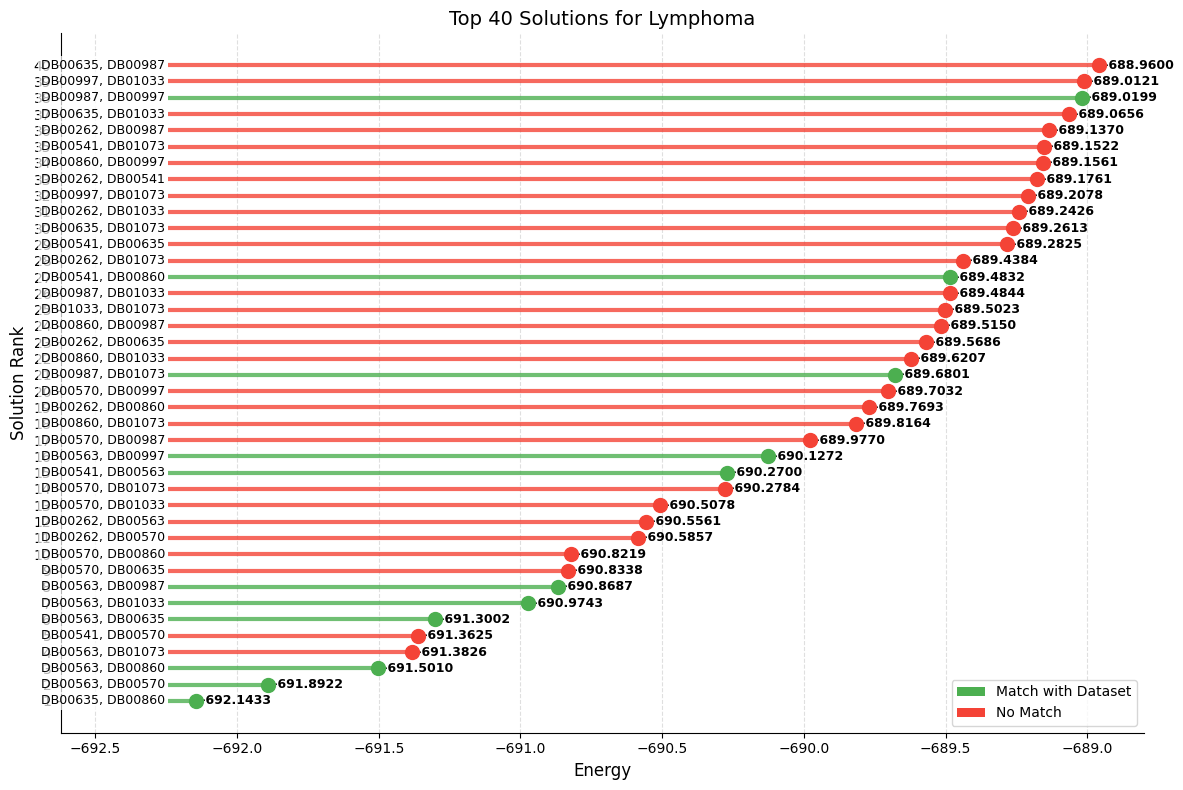

In [118]:
from qubo_selection import get_sorted_results_allowed_sizes
sorted_results = get_sorted_results_allowed_sizes(best_qubo, best_drugs, gt_combinations, allowed_sizes=[2,3])
plot_energy_spectrum(sorted_results, top_n=40, disease_name=disease)


### Example 50 'best' candidate drugs for maximizing AP

Enumerated 20825 candidates; positives=16; AP=0.438036
 #1: energy=-702.749, pos=1, sel=('DB00563', 'DB00570')
 #2: energy=-702.643, pos=1, sel=('DB00635', 'DB00860')
 #3: energy=-702.412, pos=1, sel=('DB00563', 'DB00860')
 #4: energy=-702.217, pos=1, sel=('DB00563', 'DB00635')
 #5: energy=-702.205, pos=0, sel=('DB00563', 'DB01073')
 #6: energy=-702.195, pos=0, sel=('DB03005', 'DB04114')
 #7: energy=-702.018, pos=0, sel=('DB00541', 'DB00570')
 #8: energy=-701.873, pos=1, sel=('DB00563', 'DB01033')
 #9: energy=-701.846, pos=0, sel=('DB00570', 'DB00860')
 #10: energy=-701.799, pos=0, sel=('DB00570', 'DB00635')


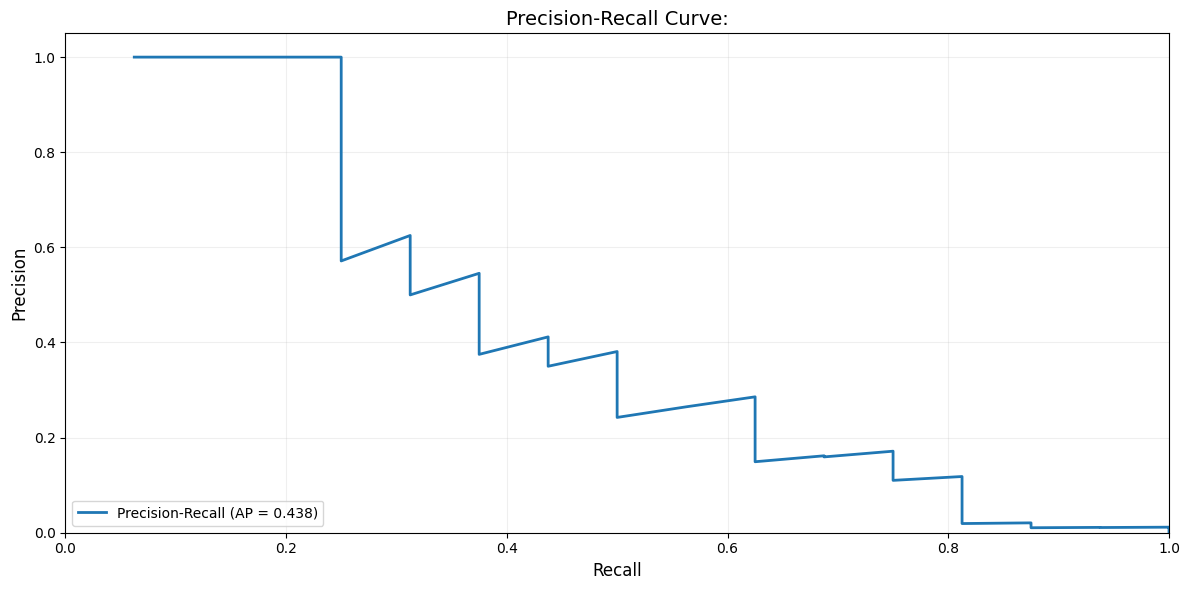

[Trial 0] ap=0.438036


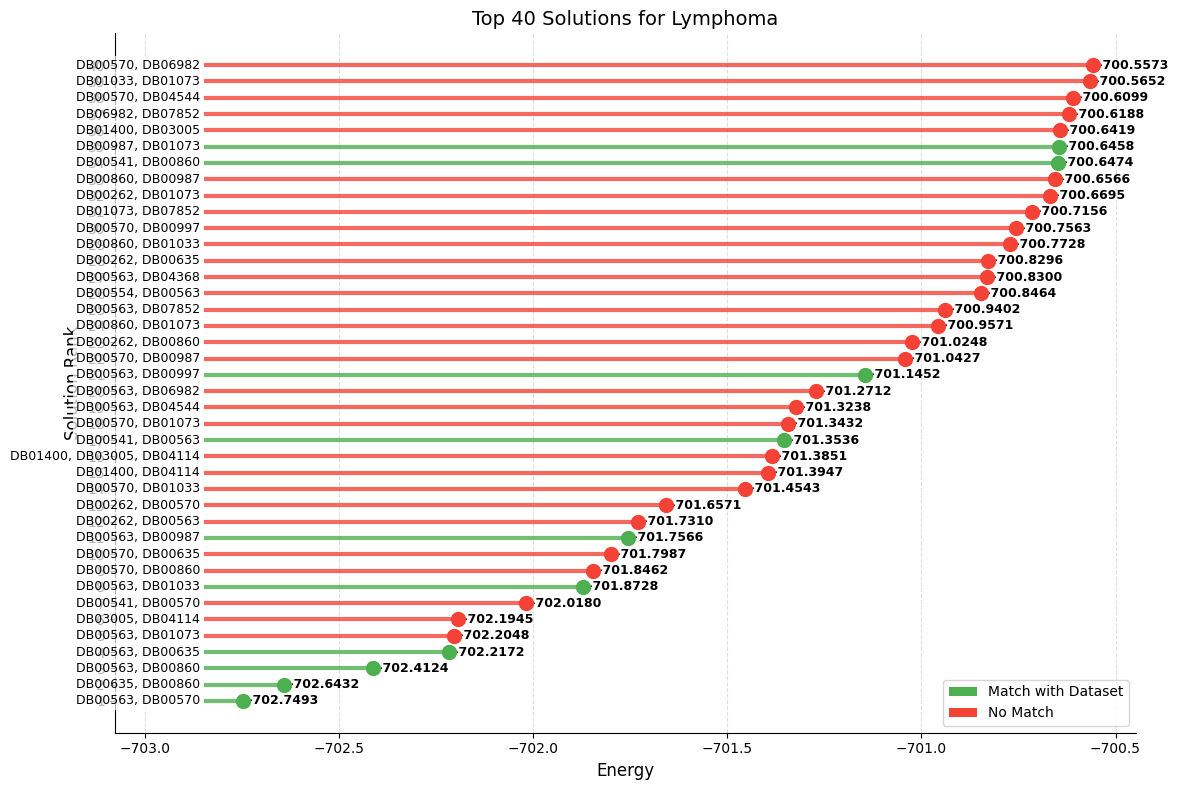

In [132]:
best_drugs = ['DB00262', 'DB00541', 'DB00563', 'DB00570', 'DB00635',
              'DB00860', 'DB00987', 'DB00997', 'DB01033', 'DB01073',
              'DB01206', 'DB03005', 'DB01526', 'DB08624', 'DB08114',
              'DB08609', 'DB00477', 'DB00673', 'DB03553', 'DB08506', 
              'DB04368', 'DB07583', 'DB06982', 'DB00549', 'DB00464',
              'DB02898', 'DB02639', 'DB00809', 'DB03824', 'DB01400',
              'DB02210', 'DB00593', 'DB01708', 'DB07529', 'DB01488', 
              'DB07553', 'DB00011', 'DB07859', 'DB04114', 'DB07754',
              'DB07852', 'DB02785', 'DB01337', 'DB04544', 'DB02118', 
              'DB00275', 'DB02647', 'DB08277', 'DB00554', 'DB07416']

num_qubits = len(best_drugs)

allowed_sizes=[2,3]
return_curve=True

best_drugs, best_qubo, best_ap, trials = find_best_qubo_for_params_ap_enumeration(
    disease_name=disease,
    df=combinations_df,
    interactome_graph=interactome_graph,
    filtered_disease_dict=filtered_disease_dict,
    drug_to_targets=drug_to_targets,
    dist_matrix=dist_matrix,
    nodes=nodes,
    node_to_idx=node_to_idx,
    initial_drug_ids=best_drugs,
    num_qubits=num_qubits,
    gamma=best_ap_gamma,
    beta=best_ap_beta,
    num_trials=num_trials,
    num_samples_for_z=z_score_samples,
    allowed_sizes=allowed_sizes,
    return_curve=return_curve,
)

sorted_results = get_sorted_results_allowed_sizes(best_qubo, best_drugs, gt_combinations, allowed_sizes=[2,3])
plot_energy_spectrum(sorted_results, top_n=40, disease_name=disease)

# Estimating Scaling

### Annealing time via gap study:

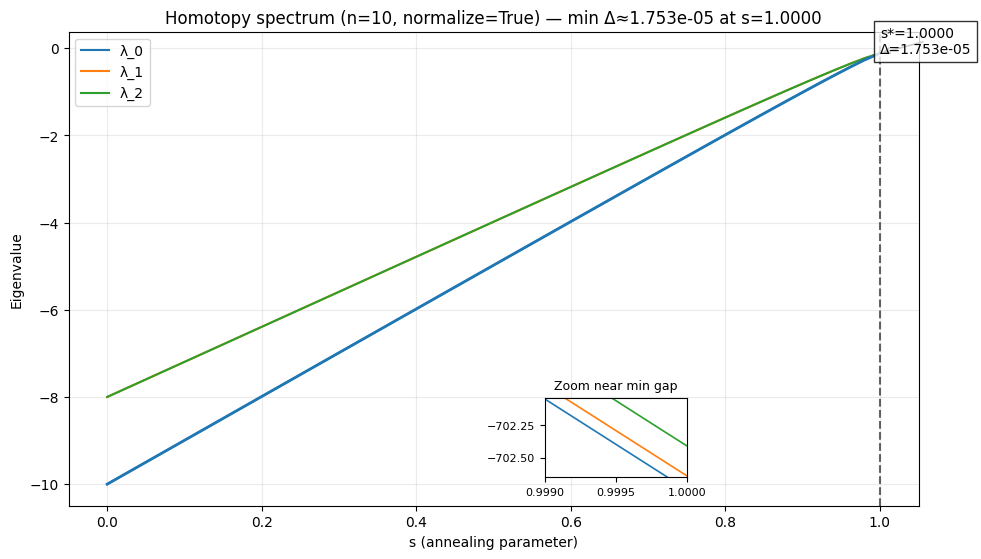

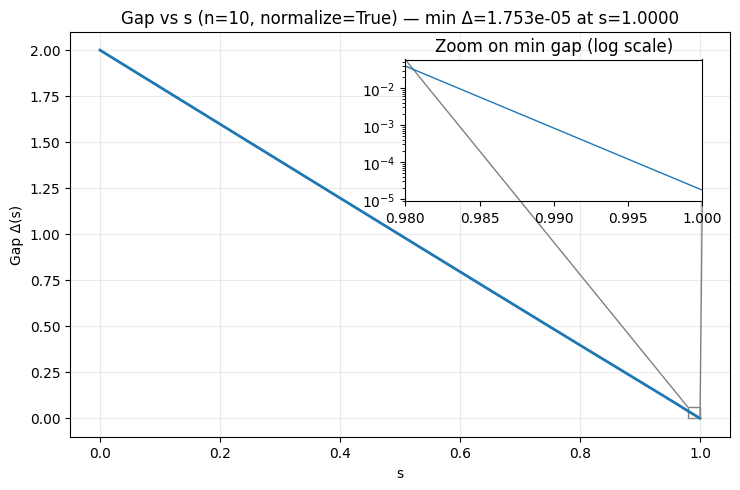

In [346]:
from scaling_estimation import plot_homotopy_eigenvalues, plot_gap_vs_s, extract_qubo_for_indices

rng = np.random.RandomState(42)

n_sub = 10

random_chosen = sorted(rng.choice(range(n_sub), size=n_sub, replace=False).tolist())
sub_random_qubo = extract_qubo_for_indices(best_qubo, random_chosen)

fig, ax = plot_homotopy_eigenvalues(sub_random_qubo, normalize=True, num_s=51, k_lowest=3, zoom_halfwidth=0.001)
fig2, ax2 = plot_gap_vs_s(sub_random_qubo, normalize=True, num_s=51)


In [199]:
from scaling_estimation import sweep_gap_vs_size

n_full = len(best_drugs)      

sizes = np.arange(6, n_full+1, 2)

sample_per_size = 7500    # how many random subsets per size (averaging / variance)
allowed_sizes = [2, 3]     # use cardinality constraint so enumeration over combos is possible and fast

full_drug_ids = best_drugs
full_qubo = best_qubo

print("Sweeping gaps (this may take a while depending on parameters)...")
t_start = time.time()
results = sweep_gap_vs_size(
    full_qubo=full_qubo,
    full_drug_ids=full_drug_ids,
    sizes=sizes,
    sample_per_size=sample_per_size,
    allowed_sizes=allowed_sizes  
)
t_total = time.time() - t_start
print(f"Finished sweep in {t_total:.2f} s. Results entries: {len(results)}")

rows = []
for rec in results:
    rows.append({
        'size': rec.get('size'),
        'sample': rec.get('sample'),
        'method': rec.get('method'),
        'E_gs': rec.get('E_gs'),
        'E_es': rec.get('E_es'),
        'gap': rec.get('gap'),
        'time_s (estimate)': rec.get('time'),
        'total_wall_time': rec.get('wall_time_total'),
        'total_candidates': rec.get('total_candidates', None)
    })
df_res = pd.DataFrame(rows)
print(df_res.head())


Sweeping gaps (this may take a while depending on parameters)...
Finished sweep in 61742.92 s. Results entries: 172500
   size  sample                     method        E_gs        E_es       gap  \
0     6       0  enumeration_allowed_sizes -698.753198 -698.482729  0.270469   
1     6       1  enumeration_allowed_sizes -702.643234 -701.024822  1.618413   
2     6       2  enumeration_allowed_sizes -700.940245 -699.232416  1.707829   
3     6       3  enumeration_allowed_sizes -700.829629 -699.936197  0.893432   
4     6       4  enumeration_allowed_sizes -699.720923 -699.620828  0.100095   

   time_s (estimate)  total_wall_time  total_candidates  
0           0.002002         0.002002                35  
1           0.003005         0.003005                35  
2           0.001994         0.001994                35  
3           0.001999         0.001999                35  
4           0.002999         0.002999                35  


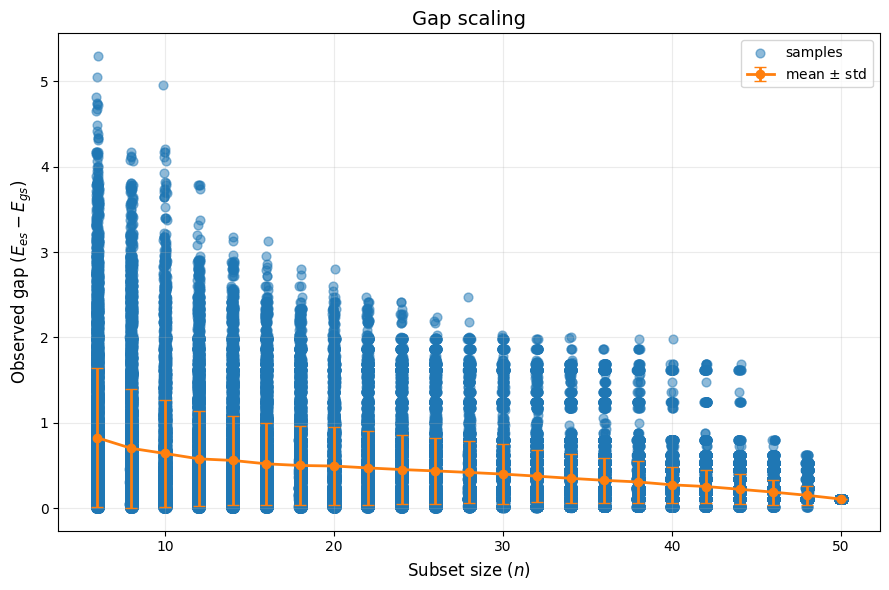

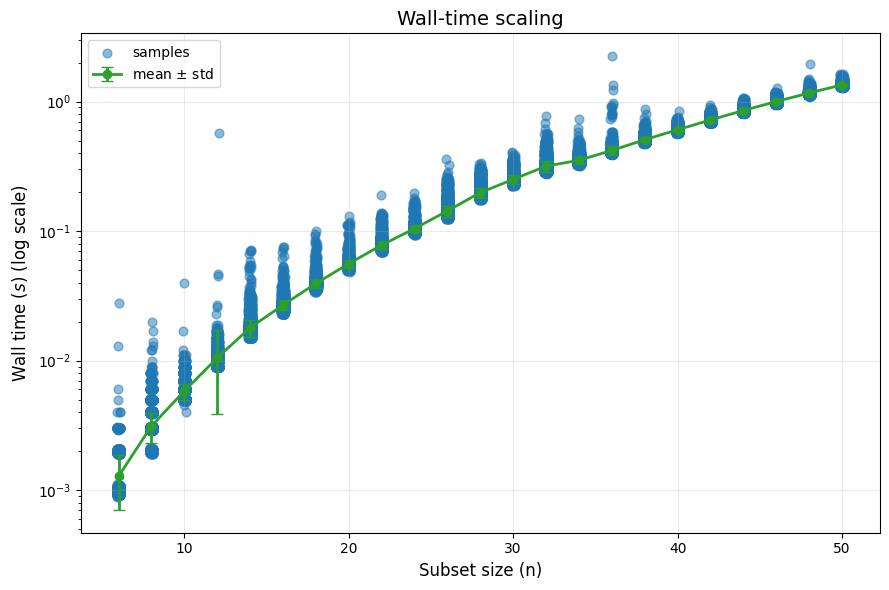

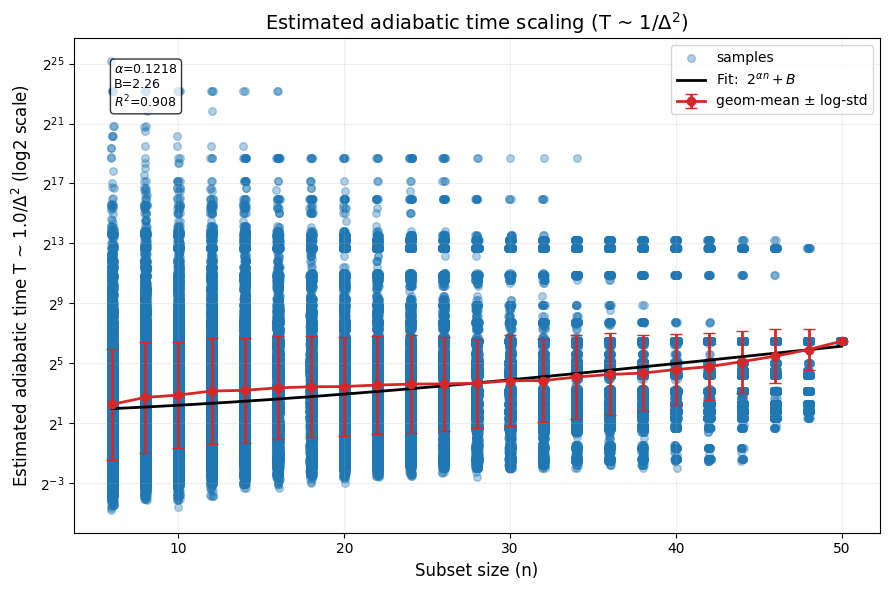

In [241]:
from scaling_estimation import plot_gap_scaling, plot_walltime_scaling, plot_adiabatic_time_scaling

fig1, ax1 = plot_gap_scaling(
    df_res,
    size_col='size',
    gap_col='gap',
    figsize=(9,6),
    title='Gap scaling'
)
plt.show(fig1)

fig2, ax2 = plot_walltime_scaling(
    df_res,
    size_col='size',
    wall_time_col='wall_time_total',
    use_log_y=True,
    figsize=(9,6),
    title='Wall-time scaling'
)
plt.show(fig2)

fig3, ax3, fit_result = plot_adiabatic_time_scaling(
    df_res,
    size_col='size',
    gap_col='gap',
    prefactor=1.0,
    eps_gap=1e-12,      
    figsize=(9,6),
    title='Estimated adiabatic time scaling (T ~ 1/$\\Delta^2$)'
)
plt.show(fig3)
